In [1]:
import sys
import os
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/src/"))
from motif.moods import import_moods_hits
from motif.tfmodisco_hit_scoring import import_tfmodisco_hits
import h5py
import numpy as np
import pandas as pd
import sklearn.metrics
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import tqdm
tqdm.tqdm_notebook()  # It is necessary to call this before the tqdm.notebook submodule is available

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "font.size": 13,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  after removing the cwd from sys.path.


### Define constants and paths

In [3]:
# Define which motifs to look at
# Motif specifications: motif name, TF/task/model, motif ID for that run
motif_specs = [
    ("Oct4-Sox2", "Oct4", ["0_0"]),
    ("Sox2", "Sox2", ["0_1"]),
    ("Nanog", "Nanog", ["0_1"])
]

head = "profile"

out_path = "/users/amtseng/tfmodisco/figures/BPnet_motif_hits_ChIPnexus"
os.makedirs(out_path, exist_ok=True)

In [4]:
# Paths to footprints, profiles, and motif hits

tf_names = ["Nanog", "Oct4", "Sox2"]

chipnexus_profile_paths = {
    tf_name : os.path.join(
        "/users/amtseng/tfmodisco/data/processed/BPNet/ChIPnexus",
        "BPNet_%s_ChIPnexus_profiles.h5" % tf_name
    ) for tf_name in tf_names
}

hits_cache_path = "/users/amtseng/tfmodisco/results/reports/motif_hits/cache/"
moods_coll_filt_hit_paths = {
    tf_name : os.path.join(
        hits_cache_path,
        "moods/BPNet",
        "BPNet_%s_ChIPseq" % tf_name,
        "BPNet_%s_ChIPseq_%s" % (tf_name, head),
        "filtered_hits.tsv"
    ) for tf_name in tf_names
}
tfm_coll_filt_hit_paths = {
    tf_name : os.path.join(
        hits_cache_path,
        "tfm/BPNet",
        "BPNet_%s_ChIPseq" % tf_name,
        "BPNet_%s_ChIPseq_%s" % (tf_name, head),
        "filtered_hits.tsv"
    ) for tf_name in tf_names
}

results_path = "/users/amtseng/tfmodisco/results/"
moods_coll_hit_paths = {
    tf_name : os.path.join(
        results_path,
        "moods/BPNet",
        "BPNet_%s_ChIPseq" % tf_name,
        "BPNet_%s_ChIPseq_%s" % (tf_name, head),
        "moods_filtered_scored_collapsed-all.bed"
    )
    for tf_name in tf_names
}
moods_hit_paths = {
    tf_name : os.path.join(
        results_path,
        "moods/BPNet",
        "BPNet_%s_ChIPseq" % tf_name,
        "BPNet_%s_ChIPseq_%s" % (tf_name, head),
        "moods_filtered_scored.bed"
    ) for tf_name in tf_names
}
tfm_coll_hit_paths = {
    tf_name : os.path.join(
        results_path,
        "tfmodisco_hit_scoring/BPNet",
        "BPNet_%s_ChIPseq" % tf_name,
        "BPNet_%s_ChIPseq_%s" % (tf_name, head),
        "tfm_matches_collapsed-all.bed"
    ) for tf_name in tf_names
}
tfm_hit_paths = {
    tf_name : os.path.join(
        results_path,
        "tfmodisco_hit_scoring/BPNet",
        "BPNet_%s_ChIPseq" % tf_name,
        "BPNet_%s_ChIPseq_%s" % (tf_name, head),
        "tfm_matches.bed"
    ) for tf_name in tf_names
}

stem = "/users/amtseng/tfmodisco/data/processed/BPNet/BPNet_motif_hits"
orig_hit_paths = {
    "Oct4": os.path.join(stem, "Oct4-Sox2_hits_peak_limited.tsv"),
    "Sox2": os.path.join(stem, "Sox2_hits_peak_limited.tsv"),
    "Nanog": os.path.join(stem, "Nanog_hits_peak_limited.tsv")
}
orig_coll_hit_paths = {
    "Oct4": os.path.join(stem, "Oct4-Sox2_hits_peak_limited_collapsed.tsv"),
    "Sox2": os.path.join(stem, "Sox2_hits_peak_limited_collapsed.tsv"),
    "Nanog": os.path.join(stem, "Nanog_hits_peak_limited_collapsed.tsv")
}

hit_types = [
    "Original",
    "Original collapsed",
    "TF-MoDISco",
    "TF-MoDISco collapsed",
    "TF-MoDISco collapsed filtered",
    "MOODS",
    "MOODS collapsed",
    "MOODS collapsed filtered"
]

hit_paths = {
    "Original": orig_hit_paths,
    "Original collapsed": orig_coll_hit_paths,
    "TF-MoDISco": tfm_hit_paths,
    "TF-MoDISco collapsed": tfm_coll_hit_paths,
    "TF-MoDISco collapsed filtered": tfm_coll_filt_hit_paths,
    "MOODS": moods_hit_paths,
    "MOODS collapsed": moods_coll_hit_paths,
    "MOODS collapsed filtered": moods_coll_filt_hit_paths
}

### Import motif hits and ChIP-nexus peaks

In [5]:
def import_motif_hits(motif_hits_path):
    """
    Imports the motif hits, which may be an output of MOODS scanning
    or TF-MoDISco hit scanning, and may be filtered hits. Depending on
    the number of columns, the hits are imported appropriately.
    """
    with open(motif_hits_path, "r") as f:
        cols = next(f).split("\t")
    if motif_hits_path.endswith(".tsv"):
        hit_table = pd.read_csv(motif_hits_path, sep="\t", header=0, index_col=None)
        if "index" in hit_table:
            hit_table = hit_table.drop("index", axis=1)
    elif len(cols) == 10:
        # MOODS hits
        hit_table = import_moods_hits(motif_hits_path)
    elif len(cols) == 16:
        # TF-MoDISco hits
        hit_table = import_tfmodisco_hits(motif_hits_path)
        
        # Sort by aggregate similarity and drop duplicates (by strand)
        hit_table = hit_table.sort_values("agg_sim")
        hit_table = hit_table.drop_duplicates(["chrom", "start", "end", "peak_index"], keep="last")
    else:
        raise ValueError("Motif hits file of unknown format/source: %s" % motif_hits_path)
    return hit_table

In [6]:
# Import all motif hits
all_hit_tables = {
    hit_type : {
        tf_name : import_motif_hits(hit_paths[hit_type][tf_name]) for tf_name in tf_names
    } for hit_type in hit_types
}  # hit type : TF name : hits

### Compute the footprint scores
For each motif of interest, obtain the edges of the footprints (relative to the center of the motif instances) for each strand, and compute the footprint scores for each motif

In [7]:
def get_motif_instance_profiles(motif_hit_table, tf_name, profile_size=100):
    """
    Given the hit table of a specific motif, obtains the set of ChIP-nexus
    profiles of length `profile_size` centered around each motif hit's center.
    Returns an N x P x 2 array of profiles for the two strands. The first
    strand is the strand the motif is on, the second strand is the opposite.
    """
    profile_path = chipnexus_profile_paths[tf_name]
    
    # Get the coordinates of the profiles
    prof_coords = motif_hit_table[["chrom", "start", "end"]].values
    mids = (prof_coords[:, 1] + prof_coords[:, 2]) // 2
    prof_coords[:, 1] = mids - (profile_size // 2)
    prof_coords[:, 2] = prof_coords[:, 1] + profile_size
    
    strands = motif_hit_table["strand"].values
    
    profiles = np.empty((len(motif_hit_table), profile_size, 2))
    with h5py.File(profile_path, "r") as f:
        for i in range(len(prof_coords)):
            chrom, start, end = prof_coords[i]
            profs = f[chrom][start:end][:, 0]
            if strands[i] == "-":
                profs = np.flip(profs)
            profiles[i] = profs
    
    return profiles

In [8]:
def compute_footprint_scores(
    profiles, strand_0_pos, strand_1_pos, divide_by_valley=False, expand=2
):
    """
    For each profile in the N x P x 2 array `profiles`, computes a footprint
    score. For each profile, computes the sum of the profile at positions
    given by `strand_0_pos` and `strand_1_pos` (indices out of P). If
    `divide_by_valley` is provided, then this sum is divided by the position
    between the two given positions. If `expand` is nonzero, then instead of
    summing just single positions, this will sum a window by extending each
    position left and right by this amount. Returns an N-array.
    """
    assert expand >= 0
    strand_0_slice = slice(
        strand_0_pos - expand, strand_0_pos + 1 + expand 
    )
    strand_1_slice = slice(
        strand_1_pos - expand, strand_1_pos + 1 + expand 
    )
    
    strand_0_sum = np.sum(profiles[:, strand_0_slice, 0], axis=1)
    strand_1_sum = np.sum(profiles[:, strand_1_slice, 1], axis=1)
    
    if divide_by_valley:
        valley_pos = (strand_0_pos + strand_1_pos) // 2
        valley_slice = slice(
            valley_pos - expand, valley_pos + 1 + expand 
        )
        valley_0_sum = np.sum(profiles[:, valley_slice, 0], axis=1)
        valley_1_sum = np.sum(profiles[:, valley_slice, 1], axis=1)
        return (strand_0_sum / valley_0_sum) + (strand_1_sum / valley_1_sum)
    else:
        return strand_0_sum + strand_1_sum

In [9]:
# Extract the motif hit tables
motif_hit_tables = []  # List of dictionaries, one for each motif; dictionary maps hit type to table
for motif_spec in motif_specs:
    motif_name, tf_name, motif_ids = motif_spec
    motif_hit_tables.append({})
    for hit_type in hit_types:
        hit_table = all_hit_tables[hit_type][tf_name]
        if hit_type.startswith("Original"):
            motif_hit_table = hit_table
        else:
            motif_hit_table = hit_table[hit_table["key"].isin(motif_ids)].copy()
        motif_hit_tables[-1][hit_type] = motif_hit_table

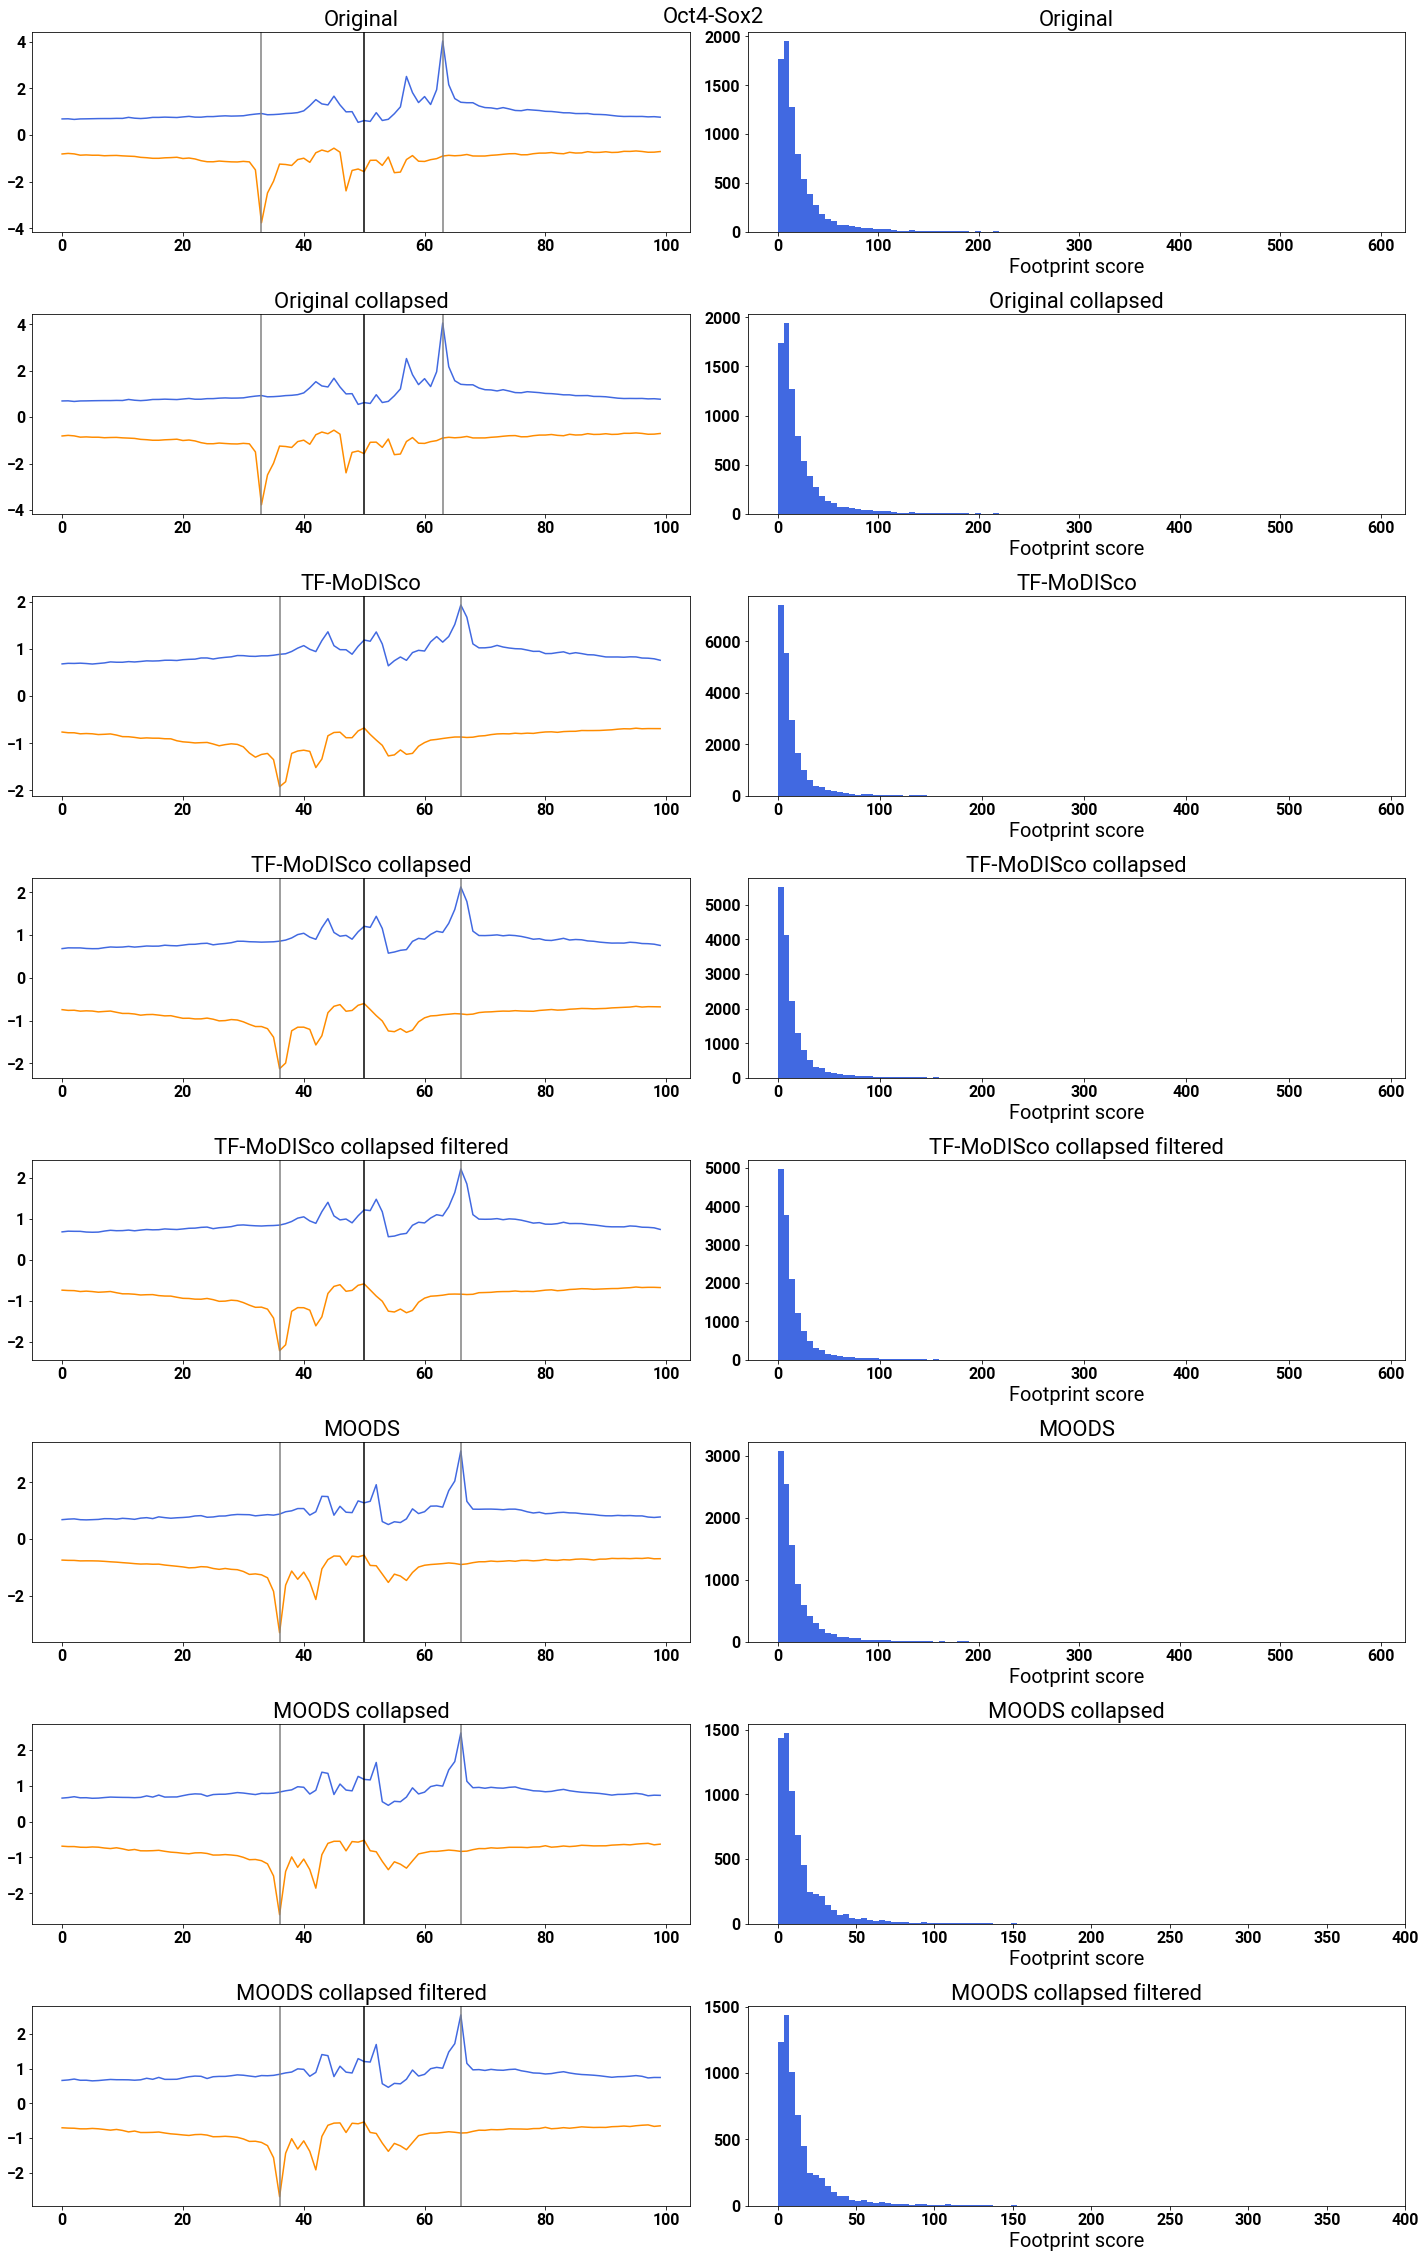

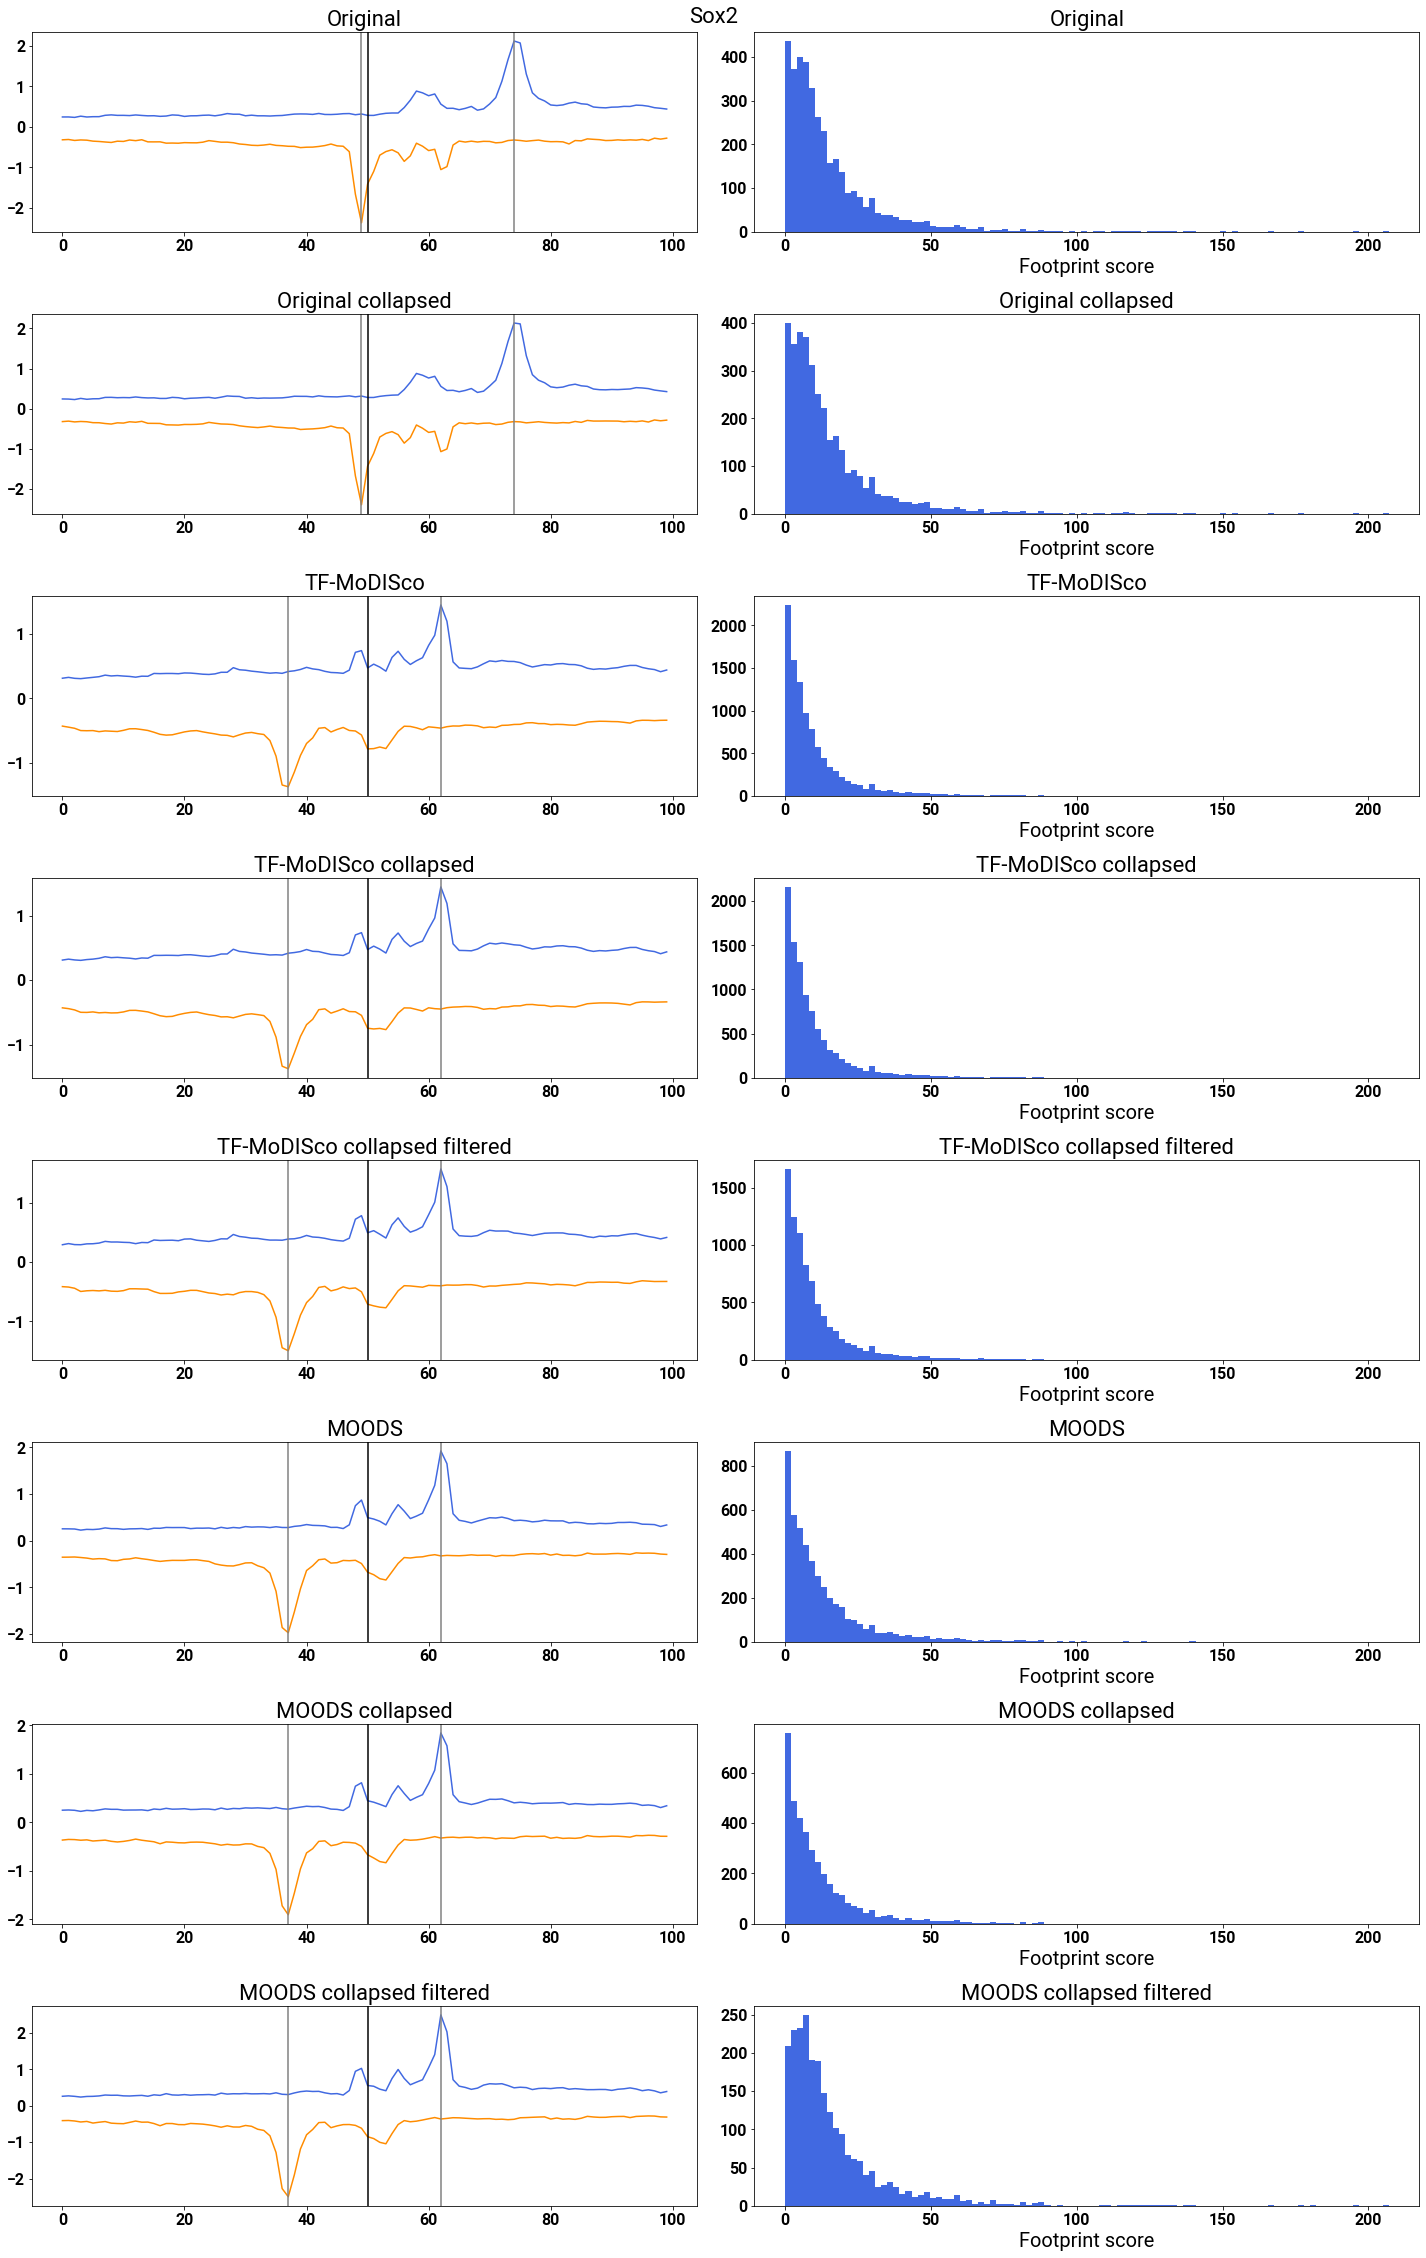

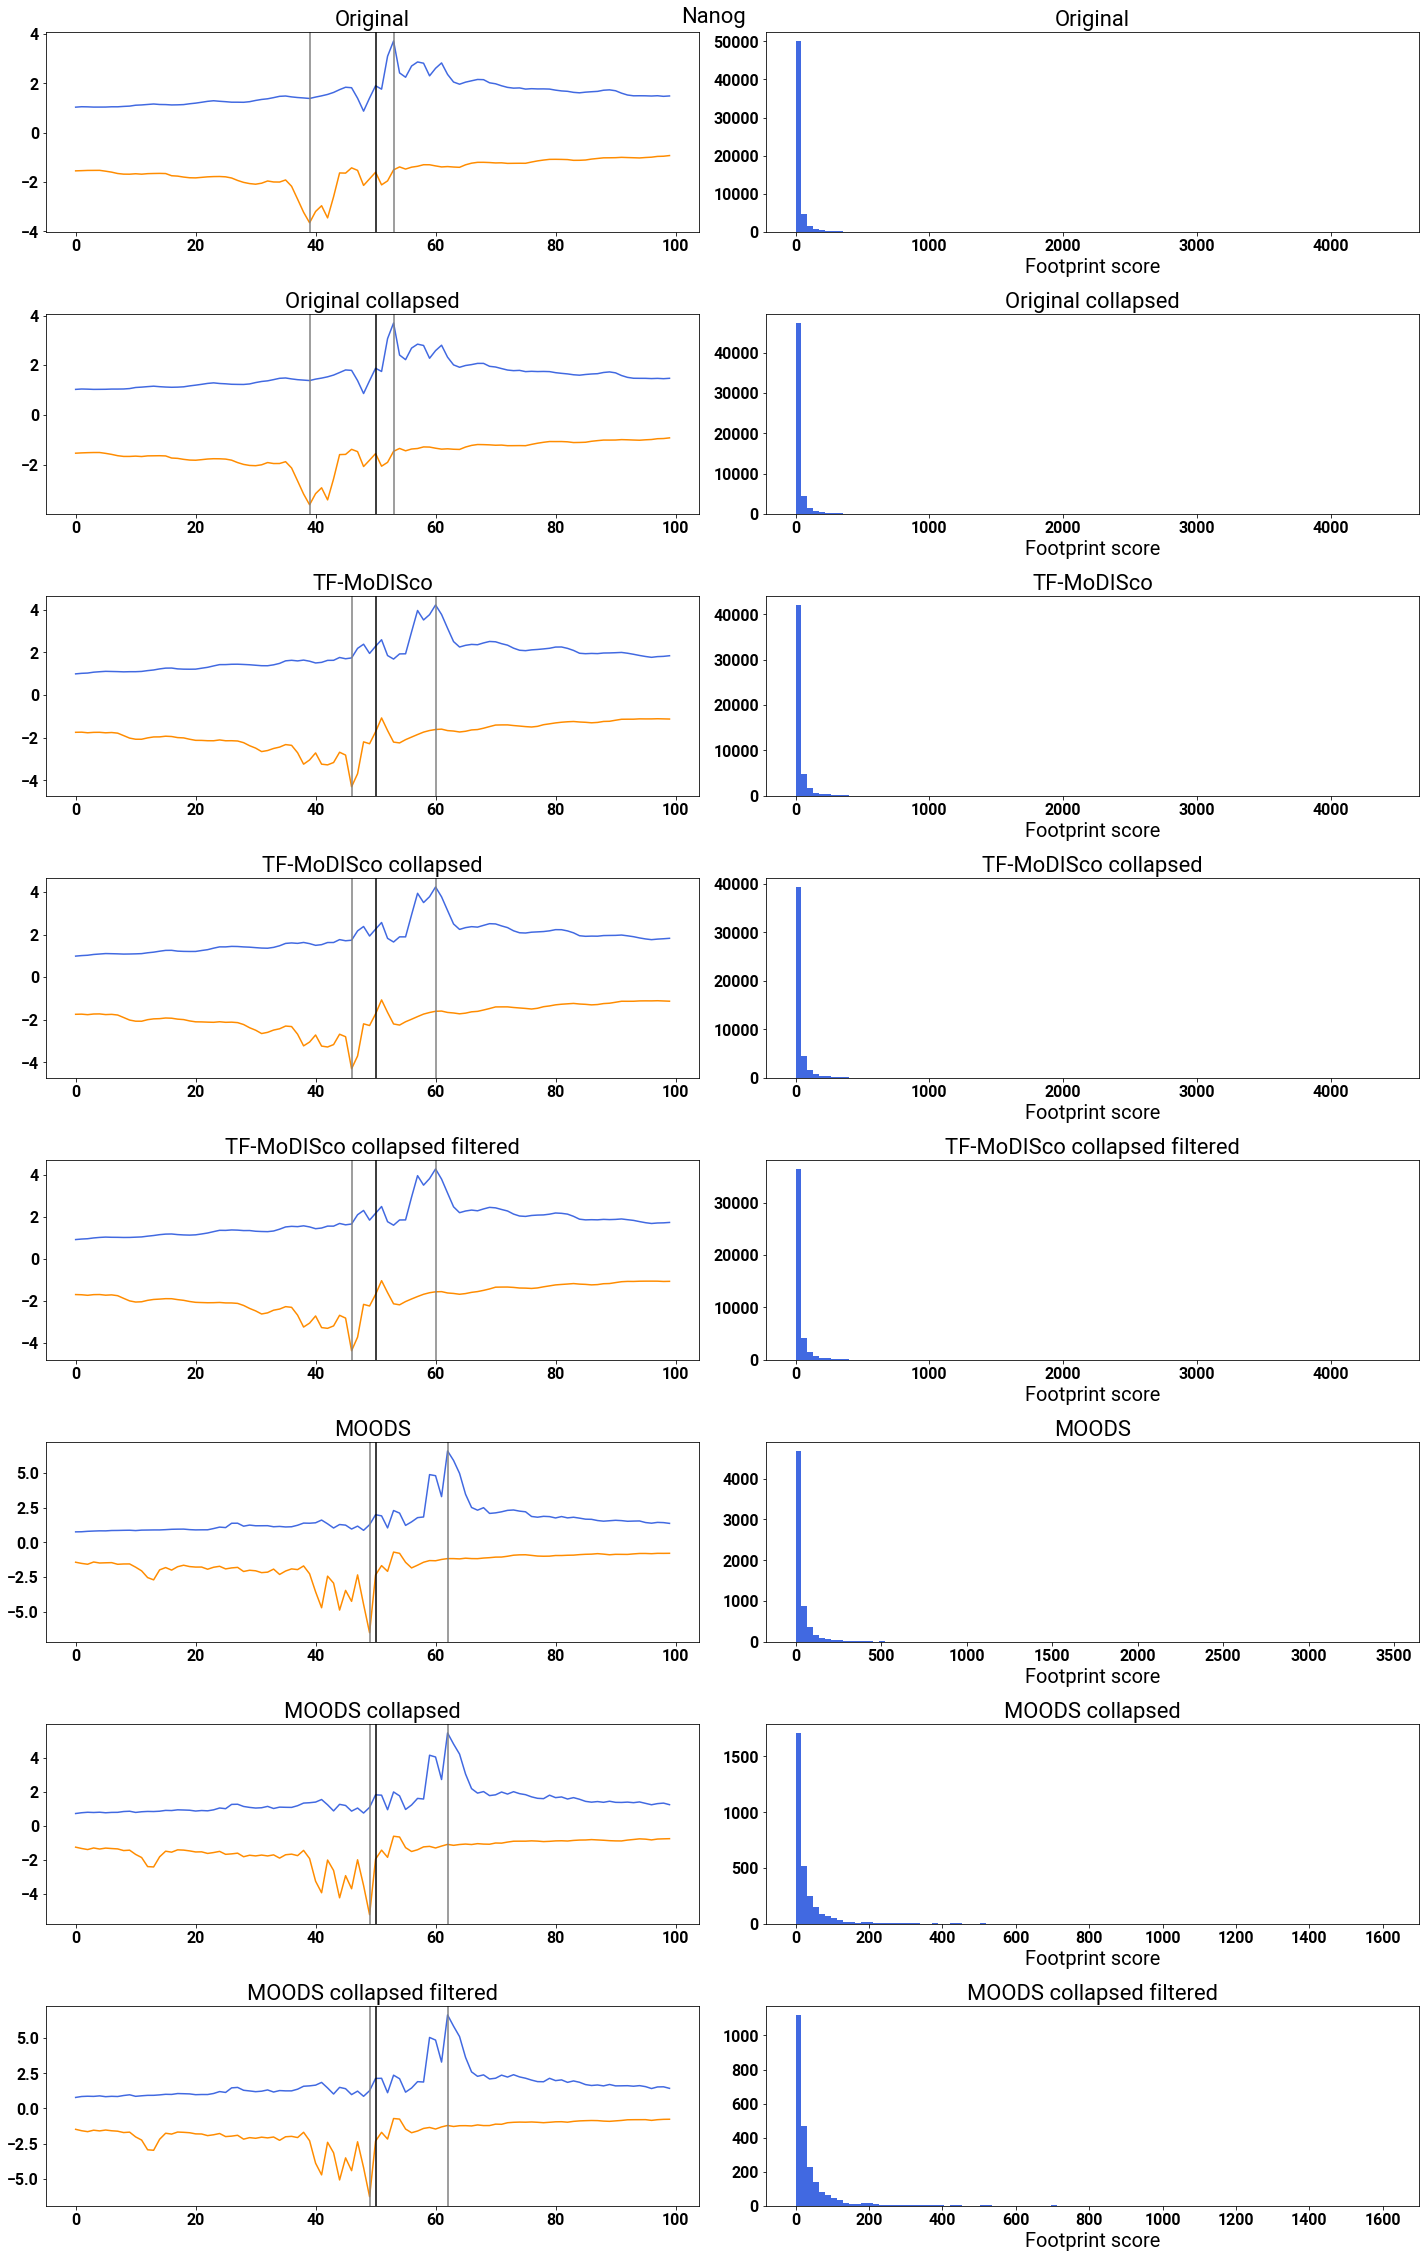

In [10]:
# Compute the footprint scores and add them as a column
for motif_i, motif_spec in enumerate(motif_specs):
    motif_name, tf_name, motif_ids = motif_spec
    
    fig, ax = plt.subplots(nrows=len(hit_types), ncols=2, figsize=(20, 4 * len(hit_types)))
    
    for hit_type_i, hit_type in enumerate(hit_types):
        motif_hit_table = motif_hit_tables[motif_i][hit_type]
        all_footprint_scores = np.empty(len(motif_hit_table))
        
        for motif_id in [None] if hit_type.startswith("Original") else motif_ids:
            # For each motif ID of this desired motif group, add in the footprint score column,
            # separately for each motif ID
            # For "original" hits, there is only one motif in the whole file
            
            if hit_type.startswith("Original"):
                mask = np.ones(len(motif_hit_table)).astype(bool)  # All True
            else:
                mask = motif_hit_table["key"] == motif_id
                            
            if not np.sum(mask):
                continue
            
            profiles = get_motif_instance_profiles(motif_hit_table[mask], tf_name)

            # Get summit of each strand from average profile
            avg_prof = np.mean(profiles, axis=0)
            strand_0_summit_pos = np.argmax(avg_prof[:, 0])
            strand_1_summit_pos = np.argmax(avg_prof[:, 1])

            # Compute footprint scores
            footprint_scores = compute_footprint_scores(
                profiles, strand_0_summit_pos, strand_1_summit_pos
            )
            all_footprint_scores[mask] = footprint_scores

            ax[hit_type_i, 0].plot(avg_prof[:, 0], color="royalblue")
            ax[hit_type_i, 0].plot(-avg_prof[:, 1], color="darkorange")
            ax[hit_type_i, 0].axvline(len(avg_prof) // 2, color="black")
            ax[hit_type_i, 0].axvline(strand_0_summit_pos, color="gray")
            ax[hit_type_i, 0].axvline(strand_1_summit_pos, color="gray")
            ax[hit_type_i, 0].set_title(hit_type)
            ax[hit_type_i, 1].hist(footprint_scores, bins=min(100, int(np.ceil(len(footprint_scores) / 10))), color="royalblue")
            ax[hit_type_i, 1].set_xlabel("Footprint score")
            ax[hit_type_i, 1].set_title(hit_type)
        
        motif_hit_table["footprint_score"] = all_footprint_scores
        
    fig.suptitle(motif_name)
    fig.tight_layout()
    plt.show()

### Show support of motif hits by footprint score

In [11]:
def get_thresh(motif_hit_table, perc=0.9, score_col="footprint_score"):
    """
    Gets the threshold of the given score column, at the given percentile.
    """
    score_vals = motif_hit_table[score_col].values
    return np.percentile(score_vals, perc * 100)

In [12]:
def get_ranked_mask(
    motif_hit_table, pos_thresh, neg_thresh=None, score_col="footprint_score",
    sort_col="imp_total_score"
):
    """
    For a table of N motif hits, orders the hits and returns a boolean mask
    of which hits are positives and which are negatives. The hits are ordered
    in descending order of `sort_col`. A hit is considered positive if its
    `score_col` value is at least `pos_thresh`, and a negative if the value is
    `neg_thresh` (by default `neg_thresh = pos_thresh`).
    All other hits will be ignored.
    """
    if neg_thresh is None:
        neg_thresh = pos_thresh
    assert pos_thresh >= neg_thresh
    
    table = motif_hit_table.sort_values(sort_col, ascending=False)
    score_vals = table[score_col].values
    
    pos_mask = score_vals >= pos_thresh
    neg_mask = score_vals < neg_thresh
    
    # Remove anything that's not a positive or negative, maintaining order
    score_vals = score_vals[pos_mask | neg_mask]
    
    return score_vals >= pos_thresh

Thresholds: {'Original': 49.0, 'Original collapsed': 49.0, 'TF-MoDISco': 33.0, 'TF-MoDISco collapsed': 35.0, 'TF-MoDISco collapsed filtered': 36.0, 'MOODS': 41.0, 'MOODS collapsed': 34.0, 'MOODS collapsed filtered': 35.0}
Final threshold: 49.0


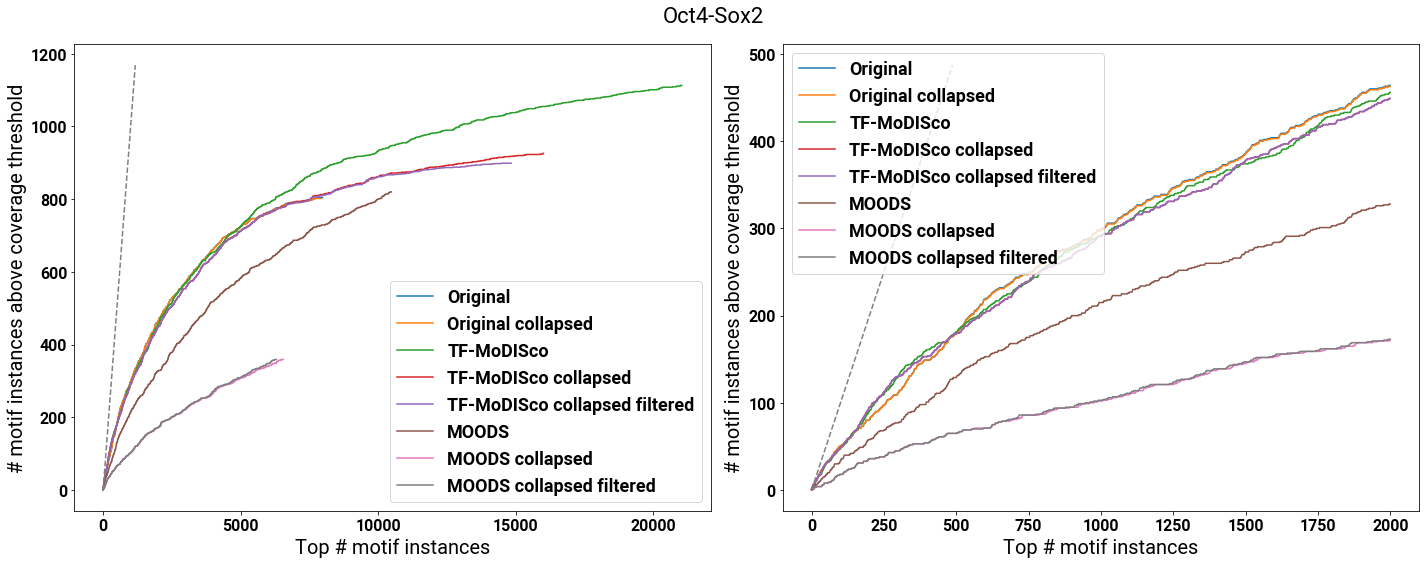

Thresholds: {'Original': 34.40000000000009, 'Original collapsed': 35.0, 'TF-MoDISco': 24.0, 'TF-MoDISco collapsed': 24.0, 'TF-MoDISco collapsed filtered': 25.0, 'MOODS': 32.0, 'MOODS collapsed': 29.0, 'MOODS collapsed filtered': 37.0}
Final threshold: 37.0


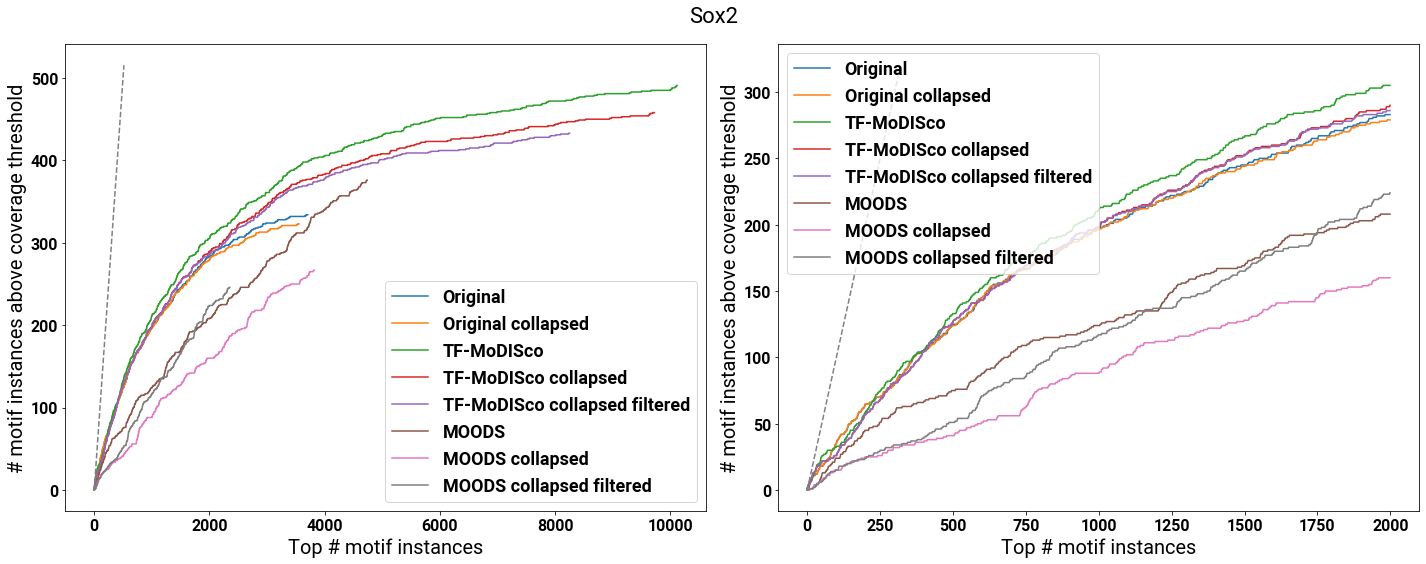

Thresholds: {'Original': 62.0, 'Original collapsed': 61.0, 'TF-MoDISco': 73.0, 'TF-MoDISco collapsed': 73.0, 'TF-MoDISco collapsed filtered': 74.0, 'MOODS': 92.0, 'MOODS collapsed': 79.59999999999991, 'MOODS collapsed filtered': 93.0}
Final threshold: 93.0


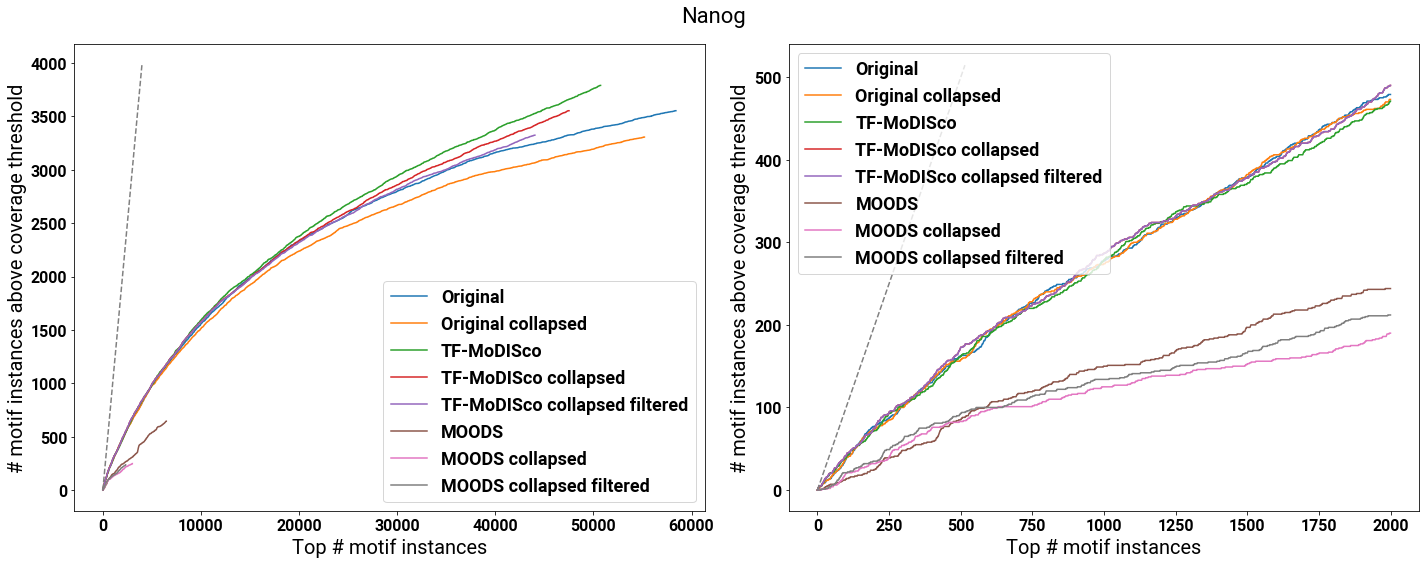

In [13]:
# Show motif hit coverage
limit_x = 2000  # Adjust this to limit x-axis

for motif_i, motif_spec in enumerate(motif_specs):
    motif_name, tf_name, _ = motif_spec
    
    fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
    
    # First, get the threshold footprint score for a positive
    pos_threshes = []
    for hit_type_i, hit_type in enumerate(hit_types):
        motif_hit_table = motif_hit_tables[motif_i][hit_type]
        pos_threshes.append(get_thresh(motif_hit_table, perc=0.9))
    pos_thresh = np.max(pos_threshes)
    print("Thresholds: %s" % {hit_types[i] : pos_threshes[i] for i in range(len(pos_threshes))})
    print("Final threshold: %s" % pos_thresh)
    
    for hit_type_i, hit_type in enumerate(hit_types):
        motif_hit_table = motif_hit_tables[motif_i][hit_type]
        if hit_type.startswith("MOODS"):
            sort_col = "score"
        elif hit_type.startswith("TF-MoDISco"):
            sort_col = "imp_ic_avg_score"
        else:
            sort_col = "imp"
        
        ranked_mask = get_ranked_mask(motif_hit_table, pos_thresh, sort_col=sort_col)
        
        ax[0].plot(np.cumsum(ranked_mask), label=hit_type)
        ax[1].plot(np.cumsum(ranked_mask[:limit_x]), label=hit_type)
    
    for i in (0, 1):
        ax[i].set_xlabel("Top # motif instances")
        ax[i].set_ylabel("# motif instances above coverage threshold")
        xmax, ymax = ax[i].get_xlim()[1], ax[i].get_ylim()[1]
        ax[i].plot([0, min(xmax, ymax)], [0, min(xmax, ymax)], linestyle="--", color="gray")
    
        ax[i].legend()
    fig.suptitle(motif_name)
    fig.tight_layout()
    plt.show()

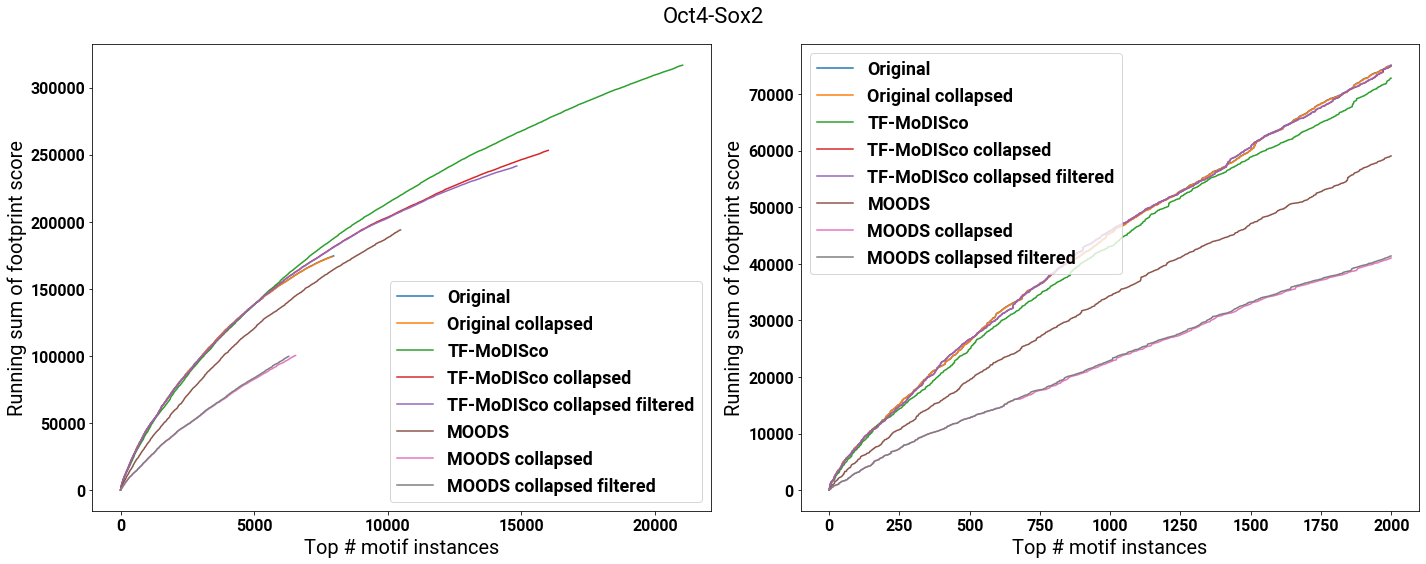

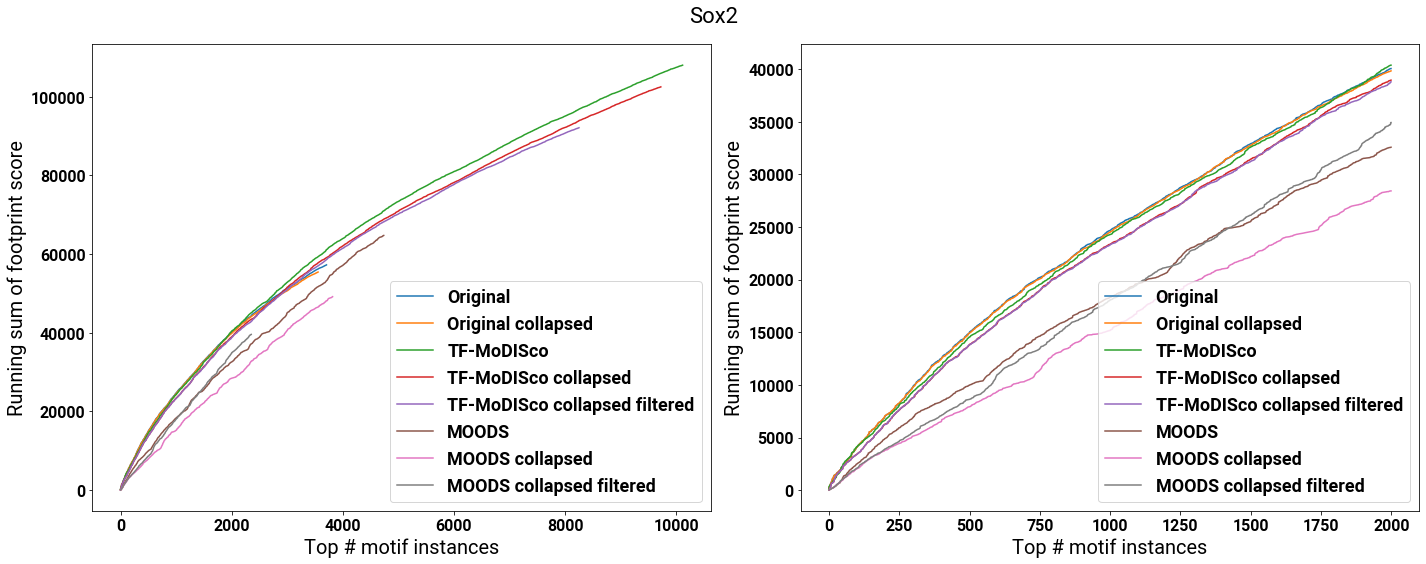

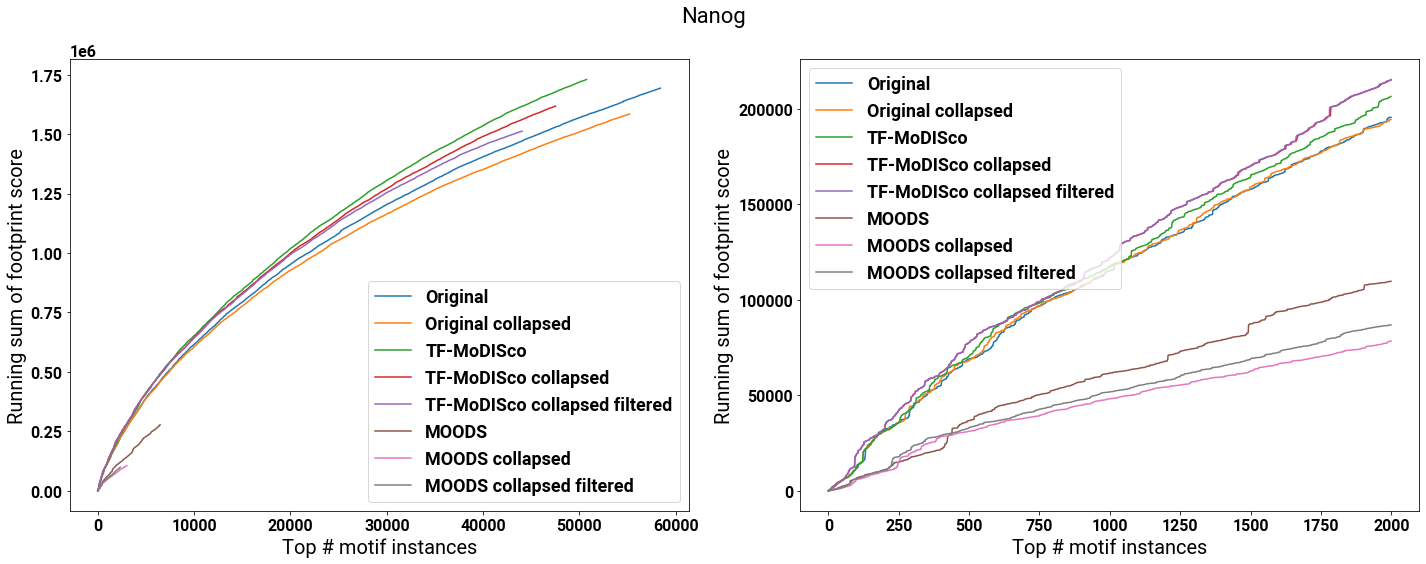

In [14]:
# Show motif hit coverage without thresholding
limit_x = 2000  # Adjust this to limit x-axis

for motif_i, motif_spec in enumerate(motif_specs):
    motif_name, tf_name, _ = motif_spec
    
    fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
    
    for hit_type_i, hit_type in enumerate(hit_types):
        motif_hit_table = motif_hit_tables[motif_i][hit_type]
        if hit_type.startswith("MOODS"):
            sort_col = "score"
        elif hit_type.startswith("TF-MoDISco"):
            sort_col = "imp_total_score"  # imp_ic_avg_score imp_total_score imp_total_signed_score
        else:
            sort_col = "imp"
        
        motif_hit_table_sorted = motif_hit_table.sort_values(sort_col, ascending=False)
        footprint_scores = motif_hit_table_sorted["footprint_score"]
        
        ax[0].plot(np.arange(len(footprint_scores)), np.cumsum(footprint_scores), label=hit_type)
        footprint_scores_limited = footprint_scores[:limit_x]
        ax[1].plot(np.arange(len(footprint_scores_limited)), np.cumsum(footprint_scores_limited), label=hit_type)
    
    for i in (0, 1):
        ax[i].set_xlabel("Top # motif instances")
        ax[i].set_ylabel("Running sum of footprint score")
        ax[i].legend()
    fig.suptitle(motif_name)
    fig.tight_layout()
    
    plt.savefig(
        os.path.join(out_path, "BPNet_motif_hit_enrichment_%s.svg" % motif_name),
        format="svg"
    )
    plt.show()

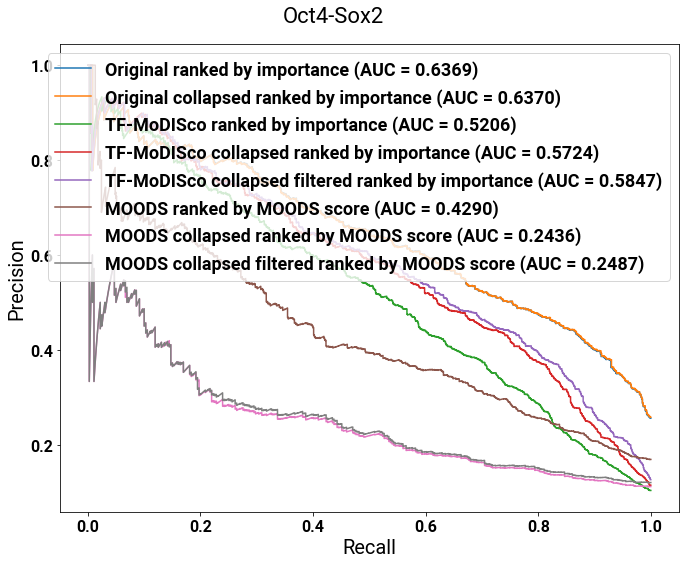

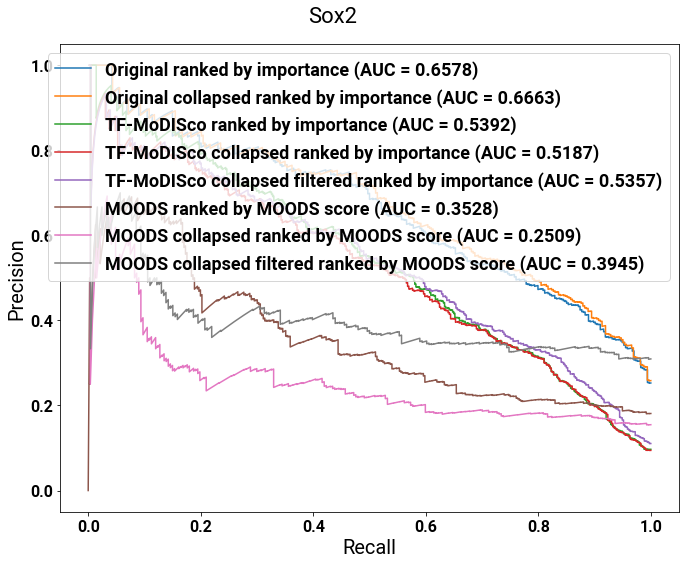

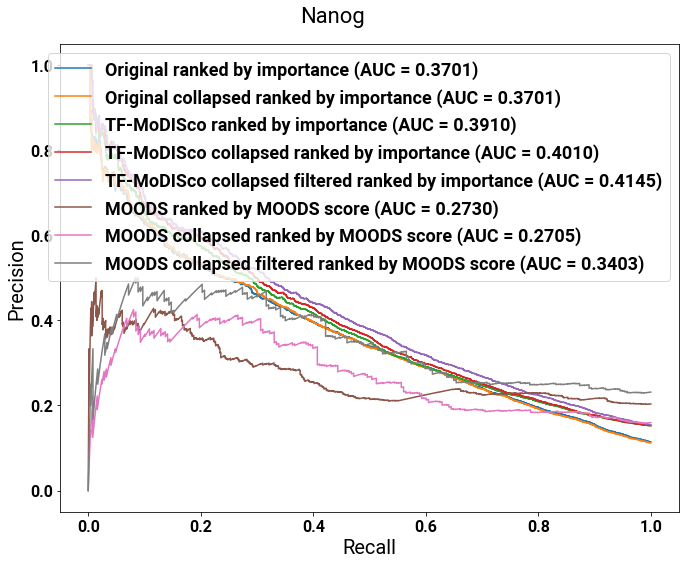

In [15]:
# Show motif hit precision-recall
for motif_i, motif_spec in enumerate(motif_specs):
    motif_name, tf_name, _ = motif_spec
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # First, get the threshold footprint scores for positives/negatives
    pos_threshes, neg_threshes = [], []
    for hit_type_i, hit_type in enumerate(hit_types):
        motif_hit_table = motif_hit_tables[motif_i][hit_type]
        pos_threshes.append(get_thresh(motif_hit_table, perc=0.9))
        neg_threshes.append(get_thresh(motif_hit_table, perc=0.5))
    pos_thresh = np.max(pos_threshes)
    neg_thresh = np.min(neg_threshes)
    
    for hit_type_i, hit_type in enumerate(hit_types):
        motif_hit_table = motif_hit_tables[motif_i][hit_type]
        score_names = {"score": "MOODS score", "imp_frac_score": "importance", "imp_total_score": "importance", "imp_ic_avg_score": "importance", "agg_sim": "similarity", "imp": "importance"}
        if hit_type.startswith("MOODS"):
            sort_cols = ["score"]  # ["score", "imp_frac_score"]
        elif hit_type.startswith("TF-MoDISco"):
            sort_cols = ["imp_ic_avg_score"]  # ["agg_sim", "imp_frac_score"]
        else:
            sort_cols = ["imp"]
        
        for sort_col in sort_cols:
            ranked_mask = get_ranked_mask(
                motif_hit_table, pos_thresh, neg_thresh=neg_thresh, sort_col=sort_col
            )        
            precis, recall, _ = sklearn.metrics.precision_recall_curve(
                ranked_mask.astype(int),
                np.flip(np.arange(len(ranked_mask))) / len(ranked_mask)
            )
            auc = sklearn.metrics.auc(recall[:-1], precis[:-1])
            ax.plot(recall[:-1], precis[:-1], label="%s ranked by %s (AUC = %.4f)" % (hit_type, score_names[sort_col], auc))
    
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend()
    fig.suptitle(motif_name)
    fig.tight_layout()
    plt.show()

### Visualize ChIP-nexus profiles around hits

In [16]:
def plot_profiles(all_profs, task_labels):
    """
    Plots the given profiles with a heatmap. `all_profs` is a list of N x P x 2
    arrays. `labels` is parallel a list of N labels.
    Returns the figure.
    """
    num_tasks = len(task_labels)
    max_num_profs = max([len(profs) for profs in all_profs])

    # Create a figure with the right dimensions
    heatmap_height = min(max_num_profs * 0.004, 8)
    agg_height = 4
    fig_height = agg_height + heatmap_height
    fig, ax = plt.subplots(
        nrows=2, ncols=num_tasks, figsize=(16, fig_height),
        gridspec_kw={
            "width_ratios": [1] * num_tasks,
            "height_ratios": [heatmap_height / fig_height, agg_height / fig_height]
        }
    )
    if num_tasks == 1:
        ax = ax[:, None]  # Add back second dimension
    
    # Compute profile means
    all_prof_means = [np.mean(profs, axis=0) for profs in all_profs]
    
    # Compute maximum profile height in average and in sum
    max_mean_height = max([np.max(profs) for profs in all_prof_means])
    
    for i in range(num_tasks):
        profs_mean = all_prof_means[i]
        
        profs = all_profs[i]
        profs_tot_sum = np.sum(profs, axis=(1, 2))

        # Order the profiles by total sum
        profs = profs[np.flip(np.argsort(profs_tot_sum))]
        
        # Sum strands
        prof_strand_sum = np.sum(profs, axis=2)
        
        # Z-score normalize, then min-max normalize
        profs_z_norm = (prof_strand_sum - np.mean(prof_strand_sum)) / np.std(prof_strand_sum)
        profs_norm = (profs_z_norm - np.min(profs_z_norm)) / np.max(profs_z_norm)
        
        # Plot the heatmap
        ax[0, i].imshow(profs_norm, interpolation="nearest", aspect="auto", cmap="Purples")

        # Plot the average profile
        ax[1, i].plot(profs_mean[:, 0], color="darkslateblue")
        ax[1, i].plot(-profs_mean[:, 1], color="darkorange")
        
        # Set axes on heatmap
        width = profs_mean.shape[1]
        delta = 50
        num_deltas = (width // 2) // delta
        labels = list(range(max(-width // 2, -num_deltas * delta), min(width // 2, num_deltas * delta) + 1, delta))
        tick_locs = [label + max(width // 2, num_deltas * delta) for label in labels]
        ax[0, i].set_xticks(tick_locs)
        ax[0, i].set_xticklabels(labels)
        ax[0, i].set_xlabel("Distance from motif center (bp)")
        ax[0, i].set_title(task_labels[i])
        
        # Set axes on average profile
        ylim = max_mean_height * 1.05  # Make 5% higher
        for i in range(num_tasks):
            ax[1, i].set_ylim(-ylim, ylim)

    return fig

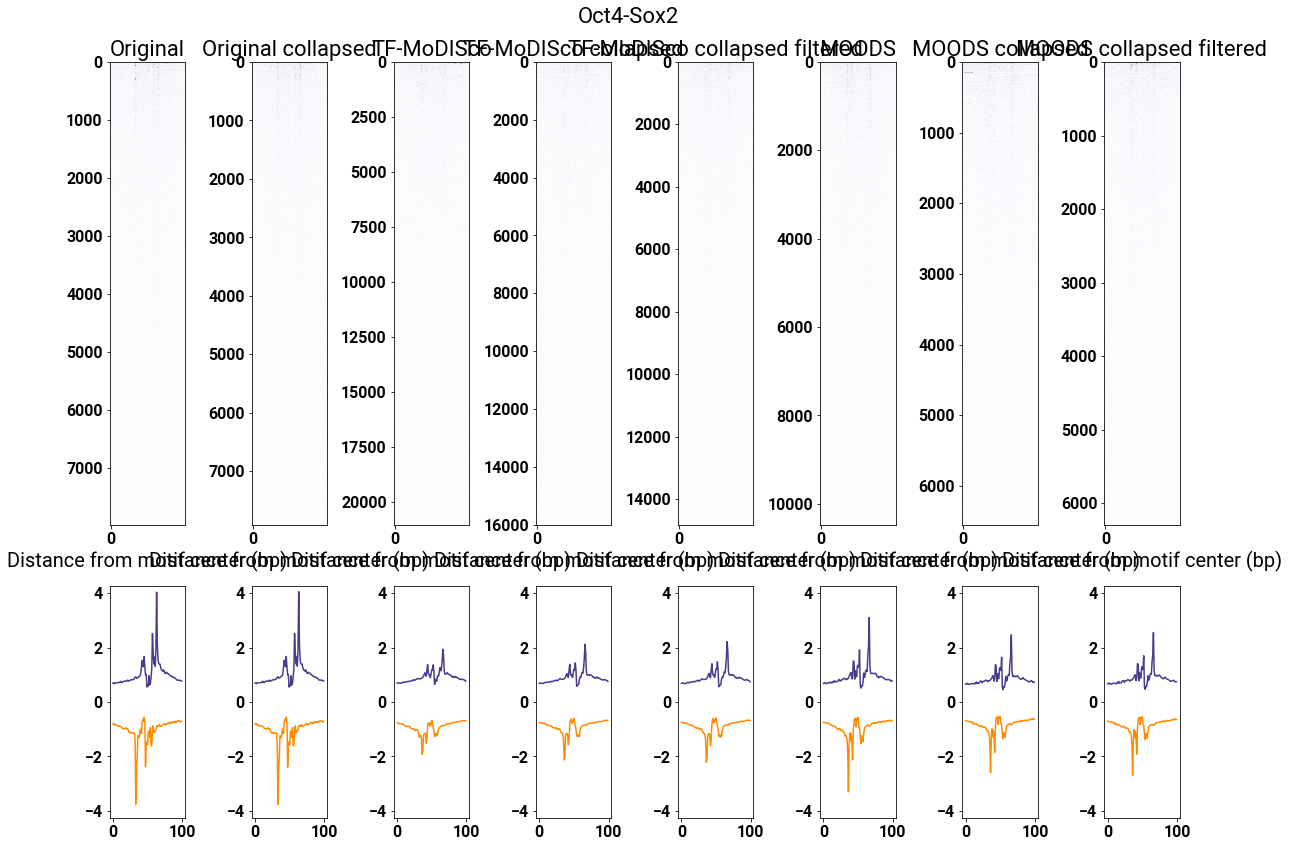

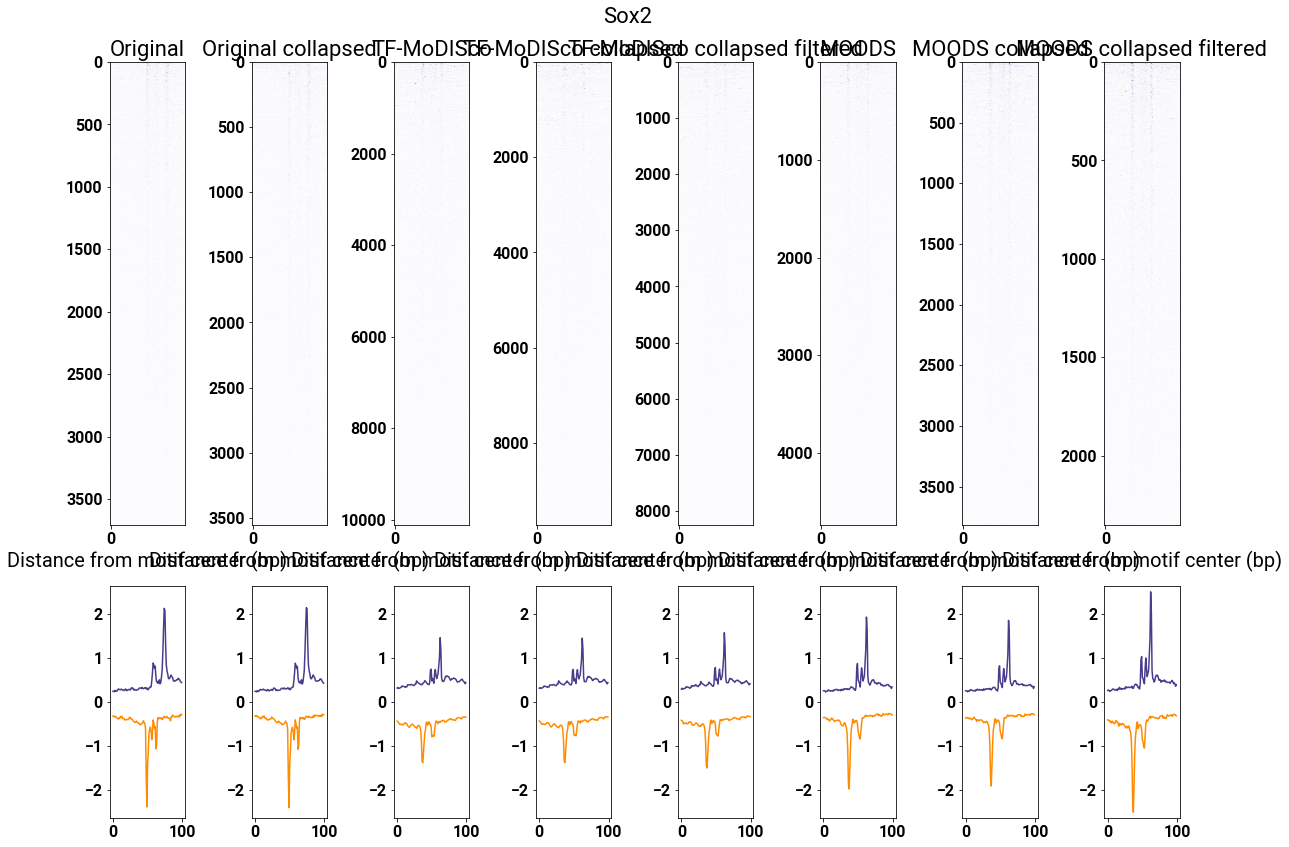

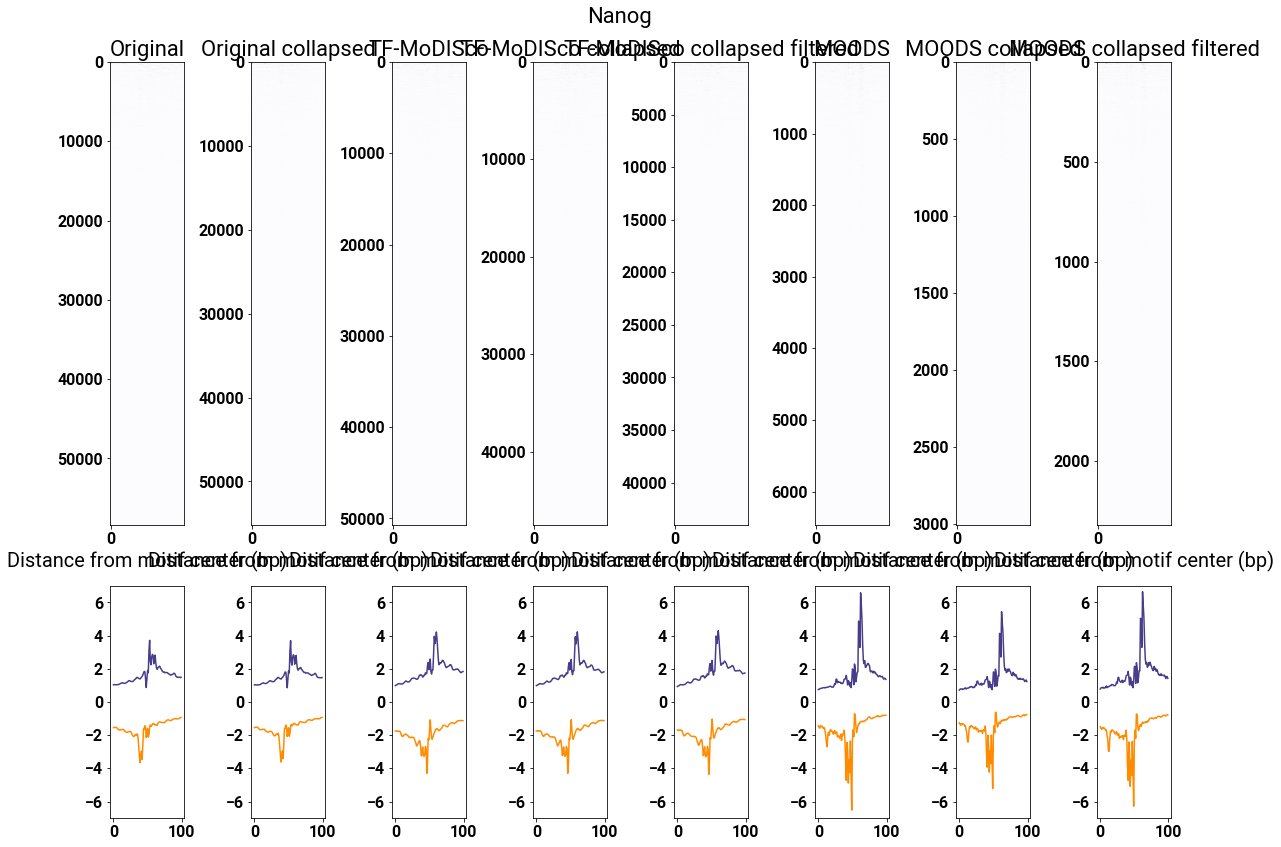

In [17]:
for motif_i, motif_spec in enumerate(motif_specs):
    motif_name, tf_name, _ = motif_spec
    
    all_profiles = [
        get_motif_instance_profiles(motif_hit_tables[motif_i][hit_type], tf_name)
        for hit_type in hit_types
    ]
    
    fig = plot_profiles(all_profiles, hit_types)
    fig.suptitle(motif_name)
    fig.tight_layout()
    plt.show()